In [6]:
import numpy as np
import matplotlib.pyplot as pp
%matplotlib inline

# Training Data

(120, 3) data


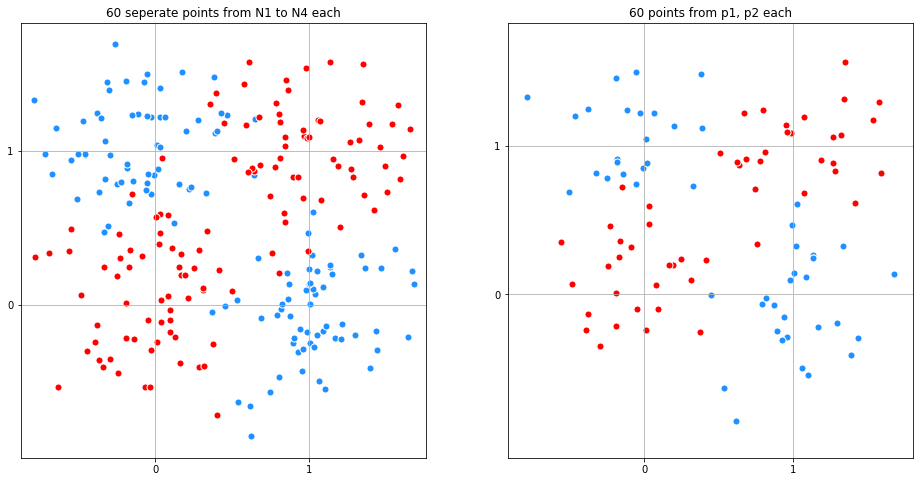

In [9]:
def scatter(data, color="dodgerblue", markers = None):
    pp.scatter(data[:,0], data[:,1], s=50, c=color, edgecolor="white")
    
n = 60
std = np.sqrt(0.1)
X1 = np.vstack([np.random.normal(0, std, n), np.random.normal(1, std, n)])
X2 = np.vstack([np.random.normal(1, std, n), np.random.normal(0, std, n)])

X3 = np.vstack([np.random.normal(0, std, n), np.random.normal(0, std, n)])
X4 = np.vstack([np.random.normal(1, std, n), np.random.normal(1, std, n)])

pp.figure(figsize=(16,8))
pp.subplot(1,2,1)
pp.title("60 seperate points from N1 to N4 each")
pp.axis('equal')
pp.xticks([0, 1])
pp.yticks([0, 1])
pp.grid()
for X in [X1, X2]:
    scatter(X.T)
for X in [X3, X4]:
    scatter(X.T, "red")

pp.subplot(1,2,2)
pp.title("60 points from p1, p2 each")
pp.axis('equal')
pp.xticks([0, 1])
pp.yticks([0, 1])
pp.grid()
Xp1 = np.hstack([X1, X2]).T
Xp1 = Xp1[np.random.choice(120, 60), :]
# scatter(Xp1)
Xp2 = np.hstack([X3, X4]).T
Xp2 = Xp2[np.random.choice(120, 60), :]
# scatter(Xp2, "red")

Y = np.hstack([-np.ones(n), np.ones(n)])
data = np.vstack([np.hstack([Xp1.T, Xp2.T]), Y]).T
scatter(data[data[:,2]==-1])
scatter(data[data[:,2]==1], "red")
print data.shape, "data"

# 6.1 k Nearest Neighbors (kNN)
Visualization: The cross ("X") marks an examplary query point, points with higher saturation are the k nearest neighbors.

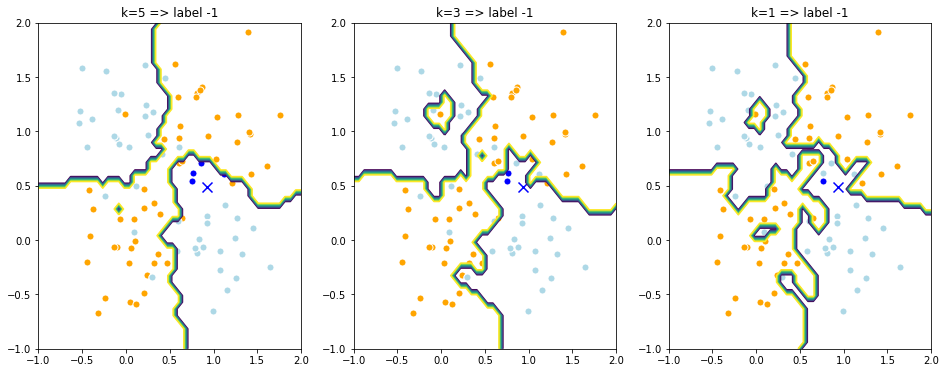

In [8]:
def knn(k, x):
    # calc k nearest neighbors
    points = data[:,:2]
    by_distances = np.argsort(np.linalg.norm(points - x, axis=1))
    k_nearest = by_distances[:k]
    
    # decide class according to majority of the labels of the nearest neighbors
    ones = np.sum((data[k_nearest,2]+1)/2)
    zeros = k - ones
    
    return 1 if ones > zeros else -1, data[k_nearest,:]

def plot_contours(k):
    # plot contours
    n = 50
    x = np.linspace(-1, 2, n)
    X, Y = np.meshgrid(x, x)
    points = np.vstack([X.reshape(n**2), Y.reshape(n**2)]).T
    #print points.shape

    Z = np.zeros(shape=(n,n)).reshape(n**2)
    for i in range(n**2):
        label, _ = knn(k, points[i])
        Z[i] = label
    Z = Z.reshape((n,n))
    pp.contour(X, Y, Z)
    return

def knn_test(k, x):
    scatter(data[data[:,2]==1, :], "orange")
    scatter(data[data[:,2]==-1, :], "lightblue")
    c, k_nearest_data = knn(k, x)
    pp.title("k=%i => label %i"%(k, c))
    reds = k_nearest_data[k_nearest_data[:,2] == 1, :2]
    blues = k_nearest_data[k_nearest_data[:,2] == -1, :2]
    scatter(reds, "red")
    scatter(blues, "blue")
    pp.scatter(x[0], x[1], marker="x", s=100, c="red" if c == 1 else "blue")
    plot_contours(k)
    return

pp.figure(figsize=(16,6))
x = np.random.rand(2)*2. -1
pp.subplot(1,3,1)
knn_test(5, x)
pp.subplot(1,3,2)
knn_test(3, x)
pp.subplot(1,3,3)
knn_test(1, x)

# 6.2 Parzen Window classifier

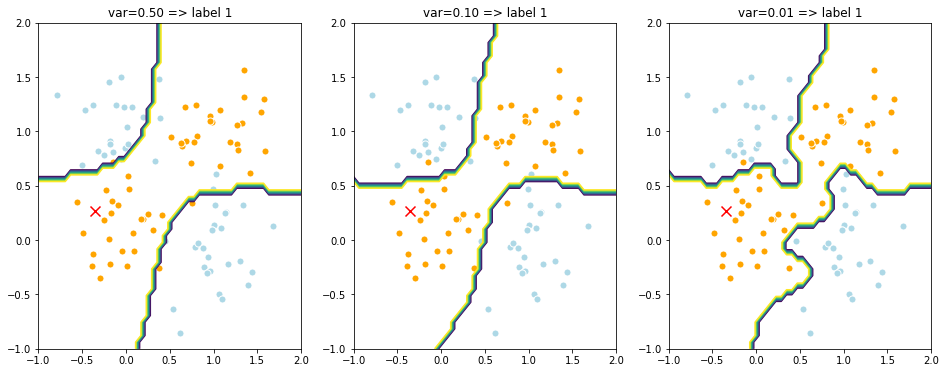

In [10]:
def gaussian(mu, variance):
    sigma = np.sqrt(variance)
    #f = lambda x: (np.exp((-(x-mu)**2) / (2.*sigma**2)) / (sigma * np.sqrt(2.*np.pi)))
    f = lambda distance: np.exp((-(distance-mu)**2) / (2.*variance))
    return f
                   
def parzen_window(x, f):
    # calc weights
    points = data[:,:2]
    distances = np.linalg.norm(points - x, axis=1)
    weights = f(distances)
    
    # decide class according to weighted average
    c = np.average(data[:,2], weights=weights)
    
    return np.sign(c)

def plot_contours2(f):
    # plot contours
    n = 50
    x = np.linspace(-1, 2, n)
    X, Y = np.meshgrid(x, x)
    points = np.vstack([X.reshape(n**2), Y.reshape(n**2)]).T
    #print points.shape

    Z = np.zeros(shape=(n,n)).reshape(n**2)
    for i in range(n**2):
        label = parzen_window(points[i], f)
        Z[i] = label
    Z = Z.reshape((n,n))
    pp.contour(X, Y, Z)
    return

def test_parzen(variance, x):
    scatter(data[data[:,2]==1, :], "orange")
    scatter(data[data[:,2]==-1, :], "lightblue")

    f = gaussian(0.0, variance)
    c = parzen_window(x, f)

    pp.title("var=%.2f => label %i"%(variance, c))
    pp.scatter(x[0], x[1], marker="x", s=100, c="red" if c == 1 else "blue")

    plot_contours2(f)
    return

pp.figure(figsize=(16,6))
x = np.random.rand(2)*2. -1
for i,variance in enumerate([0.5, 0.1, 0.01]):
    pp.subplot(1,3,i+1)
    test_parzen(variance, x)

#### (c) How would you modify the two methods if you add 60 more data points from a thrid class centered on mu3 = (0.5, 0.5).T with variance = 0.05 and want to classify all data points into 3 groups?
- it wouldn't be possible any longer to classify by the mean value of the summed up classes of the nearest neighbours (6.1) / of the summed up weighed class values (6.2)

- KNN: the class of an entry data point P should be the most counted class within the k nearest neighbours of P; a decision must be found for the case, that more than one class has the highest counted value e.g. one could increase k by one till the decision is unique or choose by random

- "Parzen-Window" classifier: for each class, all weights should be summed and the class with the highest amount would be the best class

- for a better selectivity, k should be increased (6.1) / $\sigma$ should be decreased (6.2) if one of the following cases comes true:

         - more classes are applied
         - distances between the $\mu$'s of the classes shrink
         - variances of the classes become greater

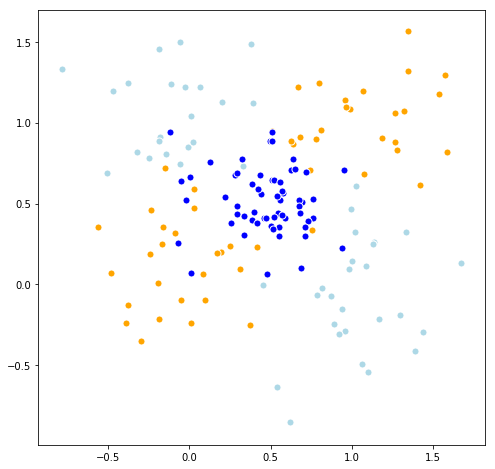

In [11]:
pp.figure(figsize=(8,8))
scatter(data[data[:,2]==1, :], "orange")
scatter(data[data[:,2]==-1, :], "lightblue")
C3 = np.vstack([np.random.normal(0.5, np.sqrt(0.05), 60), np.random.normal(0.5, np.sqrt(0.05), 60)]).T
scatter(C3, "blue")

# 6.3 Radial Basis Functions Network

(2500, 2)


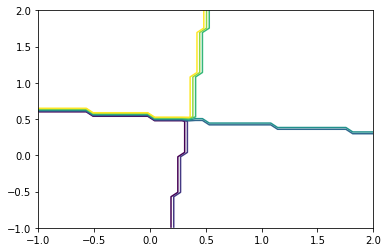

In [12]:
def kmeans(k):
    std = 0.5
    centroids = np.vstack([np.random.normal(1, std, k), np.random.normal(1, std, k)]).T
#     print centroids.shape, "centroids"
#     pp.figure(figsize=(16,8))
#     pp.subplot(1,2,1)
#     pp.title("k-means (k=4), label by nearest k-mean")
#     scatter(centroids, "orange")
#     for i,c in enumerate(centroids): pp.annotate(" %i"%i, c)

    for i in range(500):
        # choose data point x
        x = data[np.random.choice(120),:2]
#         pp.scatter(x[0], x[1], marker="x", c="0.7")
        #print x, "x"

        # determine the closest centroid t_q, q = argmin(r): |t_r - x|
        q = np.argmin( np.linalg.norm(centroids - x, axis=1) )
        tq = centroids[q,:]
        #print tq, "t_%i"%q

        # change t_q according to t_q = t_q + eta(x - t_q)
        eta = 0.5 if i < 200 else 100./float(i)
        centroids[q,:] = tq + eta*(x - tq)

#     scatter(centroids, "red")
#     for i,c in enumerate(centroids): pp.annotate(" %i"%i, c)

    return centroids

def nearest_centroid(centroids, x):
    i = np.argsort(np.linalg.norm(centroids - x, axis=1))[0]
    return i

def plot_contour3(centroids):
    # plot contours
    n = 50
    x = np.linspace(-1, 2, n)
    X, Y = np.meshgrid(x, x)
    points = np.vstack([X.reshape(n**2), Y.reshape(n**2)]).T
    print points.shape
    
    Z = np.zeros(shape=X.shape).reshape(n**2)
    for i,x in enumerate(points):
        Z[i] = nearest_centroid(centroids, x)
    Z = Z.reshape((n,n))
    pp.contour(X, Y, Z)
    return

def test_kmeans():
    centroids = kmeans(4)
    plot_contour3(centroids)
    return

test_kmeans()

2 0.5
2 0.1
2 0.01
4 0.5
4 0.1
4 0.01


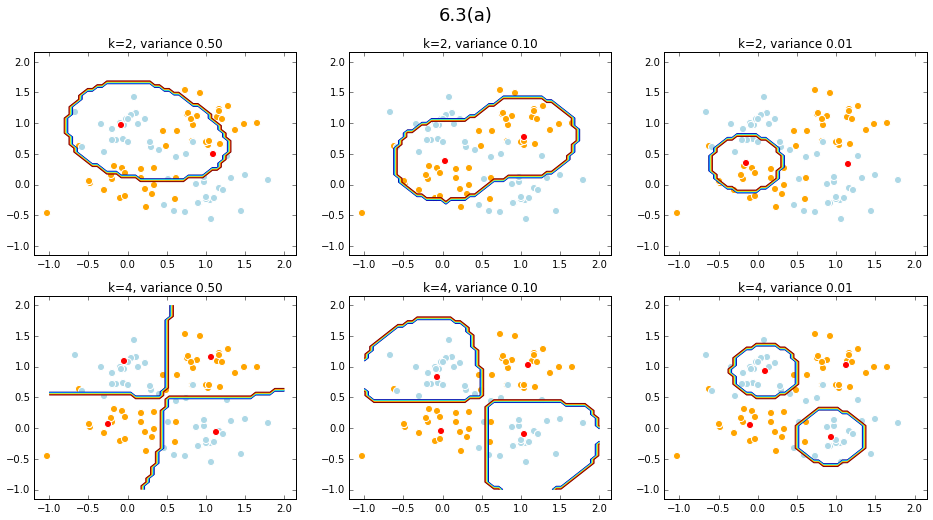

In [35]:
def rbf_gen(k, variance):
    centroids = kmeans(k)
    
    diffs = np.array([data[:,:2] - c for c in centroids])
    phi = np.vstack([np.exp(-np.linalg.norm(diffs, axis=2)/(2.*variance)), np.ones(len(data))]).T
    phi_pinv = np.linalg.pinv(phi)
    w = phi_pinv.dot(data[:,2])
    
    x = np.random.rand(2)*2.

    return centroids, w

def rbf(centroids, w, variance, x):
    # calculate phi(x)
    px = np.linalg.norm(np.array([x - c for c in centroids]), axis=1)**2
    px = np.exp(-px/(2.*variance))
    px = np.hstack([px, 1.])

    y = np.sign(w.dot(px))
    return y

def plot_contours4():
    pp.figure(figsize=(16,8))
    pp.suptitle("6.3(a)", fontsize=18)
    index = 1
    for j,k in enumerate([2,4]):
        for i,variance in enumerate([0.5, 0.1, 0.01]):
            print k, variance
            pp.subplot(2,3,index)
            pp.title("k=%i, variance %.2f"%(k,variance))
            scatter(data[data[:,2]==1, :], "orange")
            scatter(data[data[:,2]==-1, :], "lightblue")

            centroids, w = rbf_gen(k, variance)
            scatter(centroids, "red")

            n = 50
            x = np.linspace(-1, 2, n)
            X, Y = np.meshgrid(x, x)
            points = np.vstack([X.reshape(n**2), Y.reshape(n**2)]).T

            Z = np.zeros(shape=X.shape).reshape(n**2)
            for i,x in enumerate(points):
                Z[i] = rbf(centroids, w, variance, x)
            Z = Z.reshape((n,n))
            pp.contour(X, Y, Z)
            index += 1
    return

plot_contours4()


k=2, variance=0.20


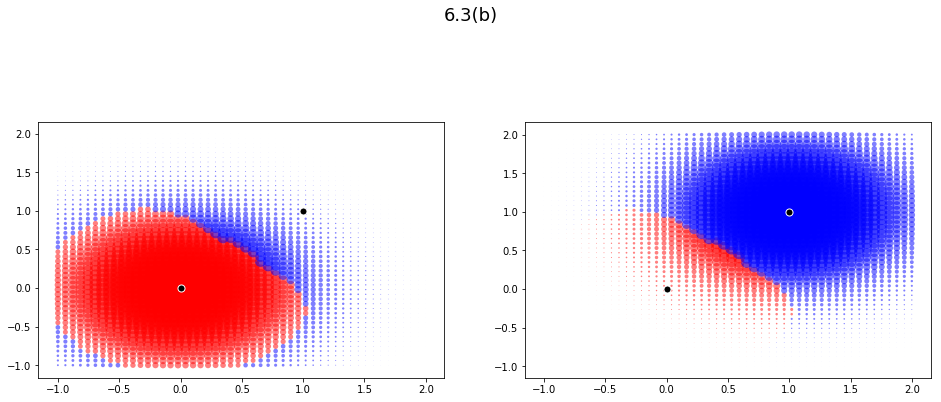

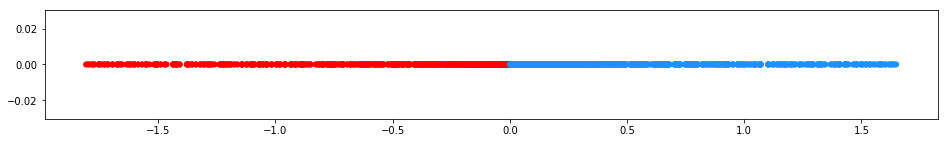

In [13]:
n = 60
reds = np.vstack([np.random.normal(1, 0.2, n), np.random.normal(1, 0.2, n)])
blues = np.vstack([np.random.normal(0, 0.2, n), np.random.normal(0, 0.2, n)])
X = np.hstack([reds, blues])
Y = np.hstack([np.ones(n), -np.ones(n)])
data = np.vstack([X, Y]).T

# pp.figure(figsize=(8,8))
# scatter(data[data[:,2]==1,:2], "red")
# scatter(data[data[:,2]==-1,:2], "blue")

def rbf_gen(centroids, variance):
    diffs = np.array([data[:,:2] - c for c in centroids])
    phi = np.vstack([np.exp(-np.linalg.norm(diffs, axis=2)/(2.*variance)), np.ones(len(data))]).T
    phi_pinv = np.linalg.pinv(phi)
    w = phi_pinv.dot(data[:,2])
    
    return centroids, w

def rbf(centroids, w, variance, x):
    # calculate phi(x)
    px = np.linalg.norm(np.array([x - c for c in centroids]), axis=1)**2
    px = np.exp(-px/(2.*variance))
    px = np.hstack([px, 1.])

    y = np.sign(w.dot(px))
    return y, px, w.dot(px)

def plot_contours5():
    pp.figure(figsize=(16,16))
    pp.suptitle("6.3(b)", fontsize=18)
    index = 1
    k = 2
    centroids = np.array([[0.0, 0.0], [1., 1.]])
    
    sigma = 0.45
    variance = sigma**2
    print "k=%i, variance=%.2f"%(k, variance)

    centroids, w = rbf_gen(centroids, variance)

    n = 50
    x = np.linspace(-1, 2, n)
    X, Y = np.meshgrid(x, x)
    points = np.vstack([X.reshape(n**2), Y.reshape(n**2)]).T

    Z = np.zeros(shape=X.shape).reshape(n**2)
    px1 = np.zeros(shape=X.shape).reshape(n**2)
    px2 = np.zeros(shape=X.shape).reshape(n**2)
    wTpxs = np.zeros(shape=X.shape).reshape(n**2)
    
    for i,x in enumerate(points):
        Z[i], px, wTpx = rbf(centroids, w, variance, x)
        px1[i] = px[0]
        px2[i] = px[1]
        wTpxs[i] = wTpx

    colors = ["red" if z == -1 else "blue" for z in Z]

    pp.subplot(3,2,index)
    pp.scatter(points[:,0], points[:,1], s=px1*500, c=colors, alpha=0.5, lw=0)
    scatter(centroids, "black")
    pp.subplot(3,2,index+1)
    pp.scatter(points[:,0], points[:,1], s=px2*500, c=colors, alpha=0.5, lw=0)
    scatter(centroids, "black")
    
    pp.figure(figsize=(16,2))
    wTpxs_sorted = np.argsort(wTpxs)
    wTpxs = wTpxs[wTpxs_sorted]
    colors = ["red" if z == -1 else "dodgerblue" for z in Z[wTpxs_sorted]]
    pp.scatter(wTpxs, np.zeros(len(colors)), c=colors, lw=0)

    index += 2
    return

plot_contours5()